In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms as tv
from typing import Dict, Tuple, List
from utils import (get_random_task, plot_task_examples, MAML)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Wstęp

W tym notebooku zobaczymy, czy algorytm MAML da się zastosować do uczenia innych architektur, a nie tylko zwykłej sieci fully connected.
Sprawdzimy to na modelu CNN, zaproponowanym w artykule MAML [1]. Opowiemy sobie o specyfikacji Query oraz Support set w ustawieniu MAML i omówimy proste zadania klasyfikacyjne na zbiorach MNIST oraz Omniglot.

# MNIST
Rozważamy problem klasyfikacji few-shot, dokładniej mówiąc: N-way K-shot na zbiorze MNIST.
Co znaczy N-way K-shot? Liczba N będzie mówić o tym, ile klas (tutaj cyfr) będziemy brać pod uwagę w zadaniu klasyfikacyjnym.
Na przykład, 10-way klasyfikacja brałaby pod uwagę wszystkich 10 klas obecnych w MNIST (labele od 0 do 9), a klasyfikacja 5-way: losowy podzbiór 5 z 10 klas.
Liczba K natomiast będzie mówić o tym, ile będziemy mieć przykładów treningowych na każdą z tych klas. Tak więc zbiór treningowy w takim ustawieniu będzie liczności N*K.

W tym celu potrzebować będziemy odpowiedniego podziału zbioru MNIST na podzadania (eng. subtasks), które będą rozwiązywać mniejszy problem - np. rozróżniania między 1, 2 i 5. Z tych podzadań losować będziemy zbiory potrzebne do trenowania modelu.

Najpierw ładujemy nasze dane testowe i treningowe:

In [4]:
transforms = tv.Compose([tv.ToTensor(), tv.Resize((28,28), antialias=None)])
dataset = torchvision.datasets.MNIST(root='./data', download=True, train=True,
                           transform=transforms)
test_dataset = torchvision.datasets.MNIST(root='./data', download=True, train=False,
                           transform=transforms)

## Support oraz Query set na zbiorze treningowym
Czym dla nas będą Support oraz Query set? W typowym ustawieniu few-shot learningu, Support set jest zbiorem, na którym wykonujemy uczenie parametrów modelu. Query set stanowi natomiast zbiór ewaluacyjny (tak więc zawiera innych reprezentantów tych samych klas). Wobec tego w typowym ustawieniu, na Query secie sprawdzalibyśmy tylko jakość predykcji.
**W przypadku uczenia z wykorzystaniem algorytmu MAML Query set jest wykorzystywany dodatkowo w procesie fine-tuningu parametrów modelu, tak więc na nim również odbywa się nauka.**

Omówmy, w jaki sposób dokonamy u nas podziału na Support oraz Query sets w ustawieniu uczenia n-way k-shot MAML:

Rozważamy zbiór treningowy naszych danych.

1) Losujemy n klas spośród wszystkich możliwych (bez powtórzeń) - to będzie charakteryzować problem, który chcemy rozstrzygnąć.

2) Tworzymy Support set: dla każdej wylosowanej klasy znajdujemy po k przykładów (obrazków) - reprezentantów tej klasy. To będzie nasz podstawowy zbiór uczący dla danego zadania.

3) Tworzymy Query set: powinien on zawierać inne przykłady obrazków klas obecnych w odpowiadającym mu Support secie. Może być tej samej liczności (n*k) co Support set, ale równie dobrze może zawierać po jednym przykładzie lub wszystkie pozostałe przykłady ze zbioru treningowego. Query set będzie potrzebny w fazie fine-tuningu.

W naszej implementacji Query i Support set będą równoliczne. Kod implementujący podział na zbiory został zainspirowany repozytorium [2]. Żeby jeszcze lepiej zapoznać się z few-shot learningiem, można zobaczyć materiały [3] oraz [4].

## Zwizualizujmy przykładowy podział na Support oraz Query set

[UWAGA 1]: Pokazywane przykłady mają przesunięte klasy, tzn. w n-way tasku będziemy mieć zawsze labele od 0 do (n-1).

[UWAGA 2]: Niektóre przykłady lub wylosowane klasy mogą zostać pominięte w wizualizacji, funkcja rysuje maksymalnie 12 (pierwszych) przykładów z odpowiedniego zbioru.

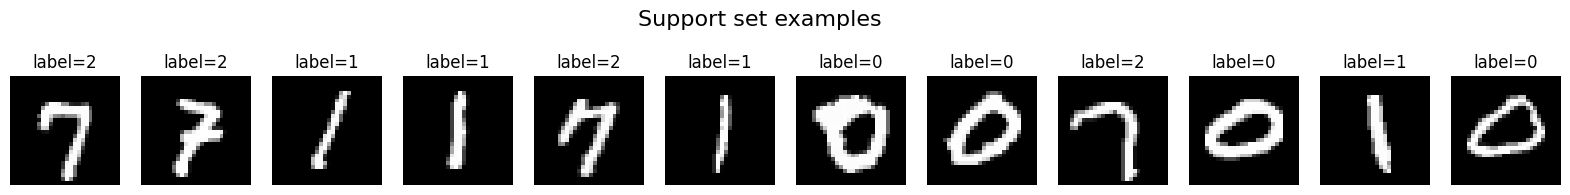

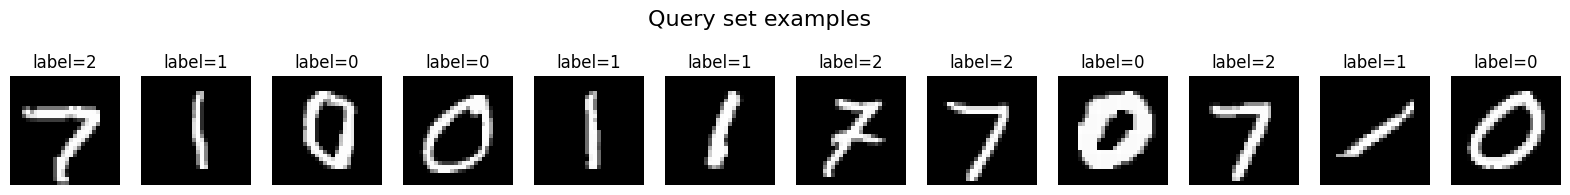

In [5]:
n_way, k_shot = 3, 4

X_support, y_support, X_query, y_query = get_random_task({'X': dataset.data, 'labels': dataset.targets}, n_way=n_way, k_shot=k_shot)
plot_task_examples(X_support, y_support, X_query, y_query)

# Definiujemy model CNN jak w artykule MAML

Teraz, żeby rozwiązać problem n-way k-shot klasyfikacji, potrzebny nam będzie jakiś klasyfikator.

Poniżej znajduje się propozycja implementacji architektury klasyfikatora CNN omawianego w artykule [MAML](https://arxiv.org/pdf/1703.03400.pdf). Wykorzystamy ten model najpierw do rozwiązania problemu klasyfikacji na zbiorze MNIST. Kod był inspirowany notebookiem [5].

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels, affine=True)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv.weight.fast = None
        self.conv.bias.fast = None
        self.bn.running_var.fast = None
        self.bn.running_mean.fast = None
        self.bn.weight.fast = None
        self.bn.bias.fast = None

    def forward(self, input: torch.Tensor):
        if self.conv.weight.fast is not None and self.conv.bias.fast is not None:
            output = F.conv2d(input, self.conv.weight.fast, self.conv.bias.fast,
                              stride=1, padding=1)
            output = F.batch_norm(output, self.bn.running_mean.fast,
                                          self.bn.running_var.fast,
                                          self.bn.weight.fast,
                                          self.bn.bias.fast,
                                          training=True)
            output = F.relu(output)
            output = F.max_pool2d(output, kernel_size=2, stride=2)

        else:
            output = self.conv(input)
            output = self.bn(output)
            output = self.relu(output)
            output = self.pool(output)

        return output


class Linear_fw(nn.Linear):
    def __init__(self, in_features, out_features):
        super(Linear_fw, self).__init__(in_features, out_features)
        self.weight.fast = None  # add fast weight link
        self.bias.fast = None

    def forward(self, x):
        if self.weight.fast is not None and self.bias.fast is not None:
            out = F.linear(x, self.weight.fast, self.bias.fast)  # weight.fast (fast weight) is the temporaily adapted weight
        else:
            out = super(Linear_fw, self).forward(x)
        return out


class Net(nn.Module):
    def __init__(self, n_classes: int = 10, in_channels: int = 1):
      super().__init__()

      self.cnn_layer1 = CNNBlock(in_channels=in_channels, out_channels=64)
      self.cnn_layer2 = CNNBlock(in_channels=64, out_channels=64)
      self.cnn_layer3 = CNNBlock(in_channels=64, out_channels=64)
      self.cnn_layer4 = CNNBlock(in_channels=64, out_channels=64)
      self.fc = Linear_fw(in_features=64, out_features=n_classes)

      self.cnn_layers = nn.Sequential(self.cnn_layer1, self.cnn_layer2, self.cnn_layer3, self.cnn_layer4)

    def forward(self, input: torch.Tensor):
        output = self.cnn_layers(input)
        output = output.view(-1,64)
        output = self.fc(output)
        return output

# Faza meta-treningu

Zaczynamy z niewytrenowanym modelem CNN, chcemy nauczyć go klasyfikować na naszych n-way k-shot zadaniach ze zbioru treningowego. Pamiętajmy, że w ustawieniu few-shot MAML model uczy się zarówno na Support jak i Query setach (ale w nieco innych momentach). Jak wspomnieliśmy, jest to różne od typowego few-shot ustawienia.

Poniżej znajduje się pętla ucząca, która aplikuje algorytm MAML do uczenia naszego modelu. Nie nadzoruje ona, czy wszystkie możliwe permutacje n-way zadań zostały wykorzystane w fazie treningu, ani czy wszystkie możliwe klasy ze zbioru treningowego były widziane przez model.

In [7]:
def train_with_MAML(dataset: Dict[str, torch.Tensor], n_way: int = 3,
                    k_shot: int = 10, grad_steps: int = 4, n_task: int = 5,
                    n_batches: int = 2, approx: bool = False) -> MAML:

    model = MAML(n_way=n_way, n_support=k_shot, n_query=k_shot, approx=approx)  # setting the order approx. needs to be done only here
    model.loss_fn = nn.CrossEntropyLoss()
    model.classifier = Net(n_classes = n_way, in_channels = 1)
    model.train()
    model.zero_grad()
    model.task_update_num = grad_steps  # number of gradient steps per each support task T_i
    model.n_task = n_task  # N different tasks T_i per batch
    model.train_lr = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # could also be SGD

    avg_loss = 0
    loss_all = []
    acc_all = []

    optimizer.zero_grad()
    torch.cuda.empty_cache()

    for b in range(n_batches):
        for i in np.arange(model.n_task):
            X_support, y_support, X_query, y_query = get_random_task(dataset, n_way=n_way, k_shot=k_shot)
            loss, accuracies, _ = model.set_forward_loss(X_support, y_support, X_query, y_query)
            task_accuracy = accuracies[-1]
            avg_loss = avg_loss + loss.item()
            loss_all.append(loss)
            acc_all.append(task_accuracy)

            if i == model.n_task - 1:
                acc_all_np  = np.asarray(acc_all)
                acc_mean = np.mean(acc_all_np)
                print(f'Batch {b+1} | Average Query Set Loss {avg_loss/float(i+1):.4f} | Support Set Average Acc {acc_mean:.2f}% | Last Query Set Acc {task_accuracy:.2f}%')

        #MAML update after each batch of tasks (task batch size == model.n_task)
        loss_q = torch.stack(loss_all).sum(0)
        loss_q.backward()
        optimizer.step()
        loss_all = []
        acc_all = []
        avg_loss = 0
        model.zero_grad()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

    return model

# Uczymy klasyfikator CNN na 3-way 10-shot taskach:

Wybór parametrów: 3-way 10-shot klasyfikacja, 4 kroki gradientowe względem support set, po 5 losowych podzadań w batchu, 20 batchy.

Czym są "batche" w tym przypadku? Zwykle batch odnosi się do danych, które będą wrzucone do modelu na wejściu. Tutaj batch odnosi się do n-way k-shot zadań na zbiorze treningowym.

Jeden batch zaiwera *n_task* losowych N-way K-shot zadań i mówimy naszemu algorytmowi, żeby powtórzył proces losowania zadań i uczenia modelu *n_batches* razy.
Proponujemy uczyć model do momentu stabilizacji "Average Query Set Loss".

In [9]:
model = train_with_MAML({'X': dataset.data, 'labels': dataset.targets}, n_way = 3, k_shot = 10, n_task=5, n_batches=20)

Batch 1 | Average Query Set Loss 0.6916 | Support Set Average Acc 80.67% | Last Query Set Acc 83.33%
Batch 2 | Average Query Set Loss 0.5961 | Support Set Average Acc 84.67% | Last Query Set Acc 96.67%
Batch 3 | Average Query Set Loss 0.5274 | Support Set Average Acc 85.33% | Last Query Set Acc 100.00%
Batch 4 | Average Query Set Loss 0.4633 | Support Set Average Acc 93.33% | Last Query Set Acc 86.67%
Batch 5 | Average Query Set Loss 0.4640 | Support Set Average Acc 89.33% | Last Query Set Acc 96.67%
Batch 6 | Average Query Set Loss 0.3614 | Support Set Average Acc 94.00% | Last Query Set Acc 96.67%
Batch 7 | Average Query Set Loss 0.3431 | Support Set Average Acc 92.67% | Last Query Set Acc 83.33%
Batch 8 | Average Query Set Loss 0.3645 | Support Set Average Acc 90.67% | Last Query Set Acc 76.67%
Batch 9 | Average Query Set Loss 0.3656 | Support Set Average Acc 92.00% | Last Query Set Acc 93.33%
Batch 10 | Average Query Set Loss 0.4702 | Support Set Average Acc 84.67% | Last Query Set

Obserwacja: podczas treningu zarówno Query set jak i Support set accuracy potrafi momentami spadać. Może to być spowodowane wylosowaniem trudniejszego dla modelu zadania. Przykładowo, któraś liczba (klasa) mogła rzadko pojawiać się w podzadaniach, czy też model trafiał na porównanie liczb, które są do siebie wizualnie podobne (jak np. 1 i 7).

# Faza meta-testu:

Mamy już wstępnie wytrenowany model na odpowiednich podzadaniach ze zbioru treningowego. Teraz chcemy douczyć ten model, żeby po zobaczeniu małej liczby nowych przykładów osiągał dobre wyniki n-way klasyfikacji na danych ze zbioru testowego. Do tego etapu również będziemy potrzebować Support oraz Query sets, ale tym razem wylosowanych ze zbioru testowego.

### [UWAGA] W przypadku zbioru MNIST, w zadaniach ze zbioru testowego, podział na Support oraz Query set dla odpowiednich tasków będzie działał bardziej na zasadzie "proof of concept". Nie zadbaliśmy o to, żeby wykluczyć którąkolwiek z 10 klas ze zbioru treningowego, wobec czego potencjalnie testujemy na klasach, które model już widział, ale w innym zestawieniu. Typowo few-shotowy podział będzie zastosowany na zbiorze Omniglot.

Poniżej znajduje się funkcja implementująca douczanie (fine-tuning) parametrów modelu dla 4 losowych n-way k-shot podzadań na zbiorze testowym. Zauważmy, że tutaj "k" w stwierdzeniu k-shot może być inną liczbą niż w przypadku fazy meta-treningu. To znaczy, możemy mieć znacznie więcej lub mniej przykładów dla każdej klasy, a dla uproszczenia przyjmujemy, że liczba klas pozostaje taka sama (inaczej trzeba by było wymieniać głowę decyzyjną i uczyć ją od początku).

In [10]:
def meta_test(model: MAML, dataset: Dict[str, torch.Tensor], n_way: int = 3, k_shot: int = 10, grad_steps: int = 6):
    loss_all = []
    acc_all = []
    model.task_update_num = grad_steps  # number of gradient steps per each support task T_i

    tasks = [get_random_task(dataset, n_way=n_way, k_shot=k_shot) for _ in range(4)]

    for i, task in enumerate(tasks, 1):
      plot_task_examples(*task)

      X_support, y_support, X_query, y_query = task
      loss, accuracies, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

      task_accuracy = accuracies[-1]
      loss_all.append(loss)
      acc_all.append(task_accuracy)
      acc_all_np  = np.asarray(acc_all)
      acc_mean = np.mean(acc_all_np)

      print(f'Task {i} | Query Set Loss {loss.item():.4f} | Support Set Average Acc {acc_mean:.2f}% | Query Set Task Acc {task_accuracy:.2f}%')
      print("\n")

## Zobaczmy, jak nasz model dopasowuje się do 3-way 6-shot tasków opartych o dane ze zbioru testowego.

Wybrane parametry: 3-way 6-shot klasyfikacja, 6 kroków gradientowych względem Support set na każdym podzadaniu.

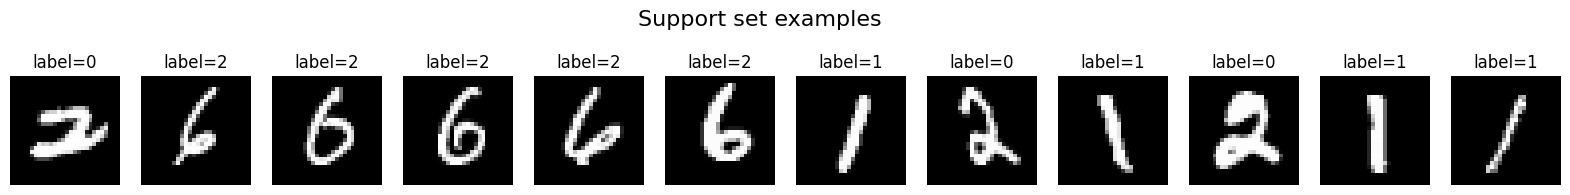

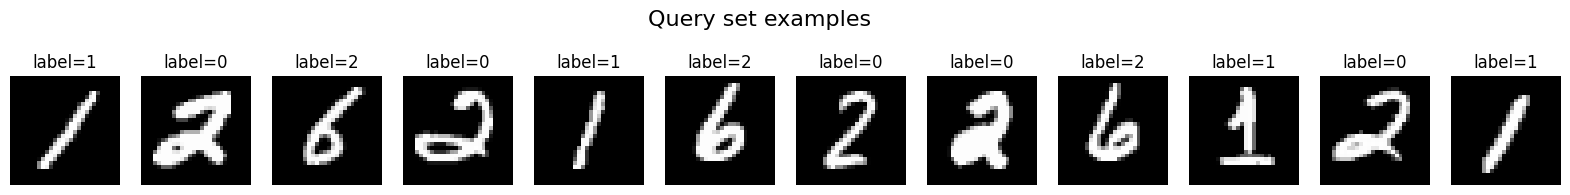

Task 1 | Query Set Loss 0.1455 | Support Set Average Acc 100.00% | Query Set Task Acc 100.00%




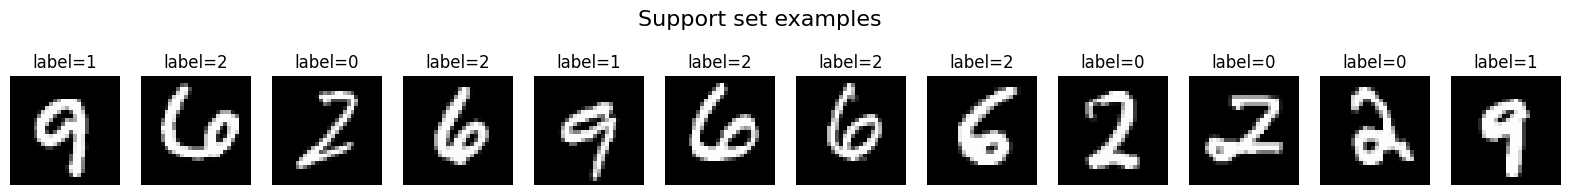

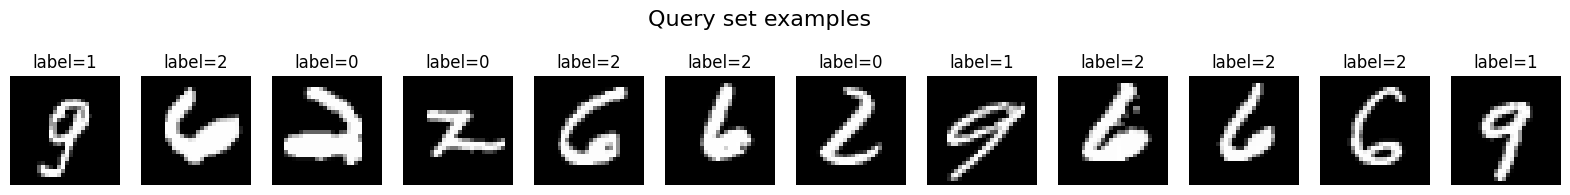

Task 2 | Query Set Loss 0.1684 | Support Set Average Acc 100.00% | Query Set Task Acc 100.00%




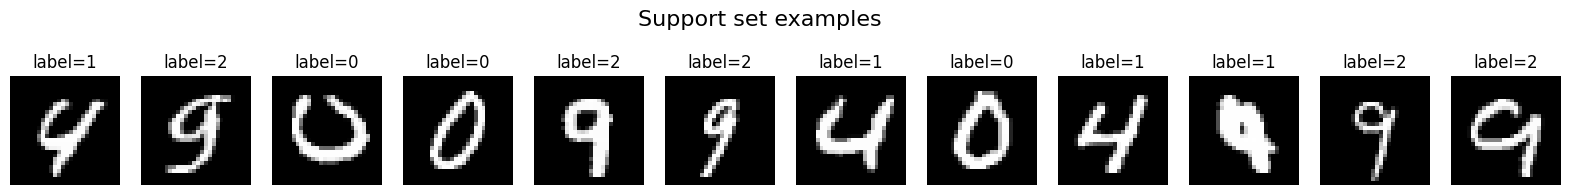

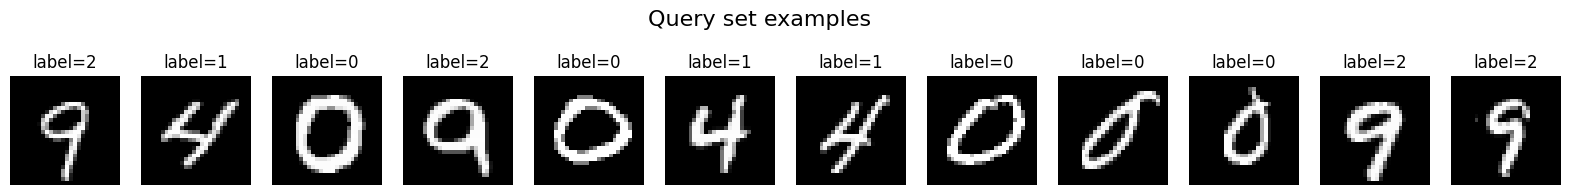

Task 3 | Query Set Loss 0.2428 | Support Set Average Acc 98.15% | Query Set Task Acc 94.44%




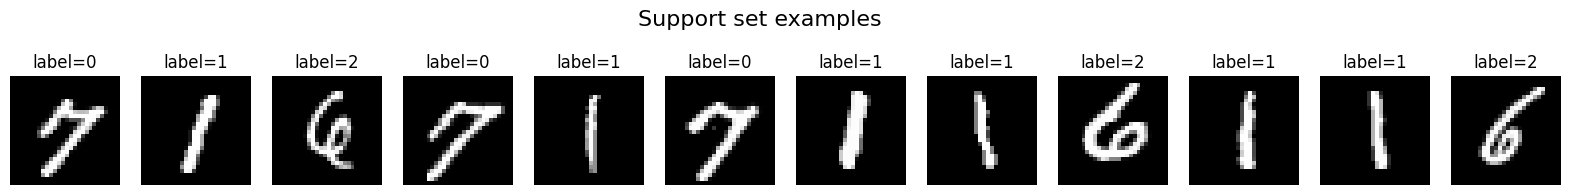

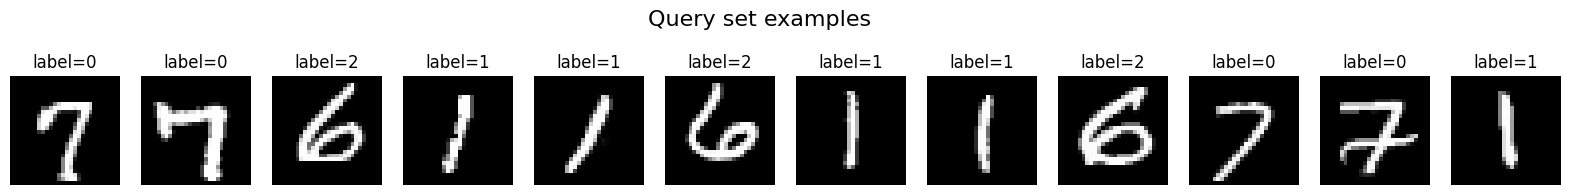

Task 4 | Query Set Loss 0.1506 | Support Set Average Acc 97.22% | Query Set Task Acc 94.44%




In [11]:
meta_test(model=model, dataset={'X': test_dataset.data, 'labels': test_dataset.targets}, n_way=3, k_shot=6, grad_steps=6)

Wnioski: W małej liczbie kroków jesteśmy w stanie douczyć model tak, żeby radził sobie z klasyfikacją nowych przykładów.

Tutaj zadanie było proste - w zbiorze MNIST mamy tylko 10 klas, a co więcej, żadna z klas nie jest wykluczona ze zbioru treningowego. Zatem model prawdopodobnie widział już wszystkie liczby (w jakimś losowym zestawieniu) w fazie meta-treningu. Trudnością tutaj jest głównie nowość przykładów.

Zadanie na zbiorze Omniglot będzie nieco trudniejsze.

# Zadanie 1.
## a) Jak rozumiesz podział zbiorów na Support oraz Query set wykorzystywany w fazach meta-treningu i meta-testu? Czy zbiory te muszą być równoliczne?

## b) Czym charakteryzuje się n-way k-shot task? Jakie trudności może nieść za sobą zwiększenie liczby rozważanych klas lub zmniejszenie liczby przykładów na klasę?

Odpowiedź:

a) Support oraz Query set reprezentują to samo zadanie decyzyjne, przy zachowaniu rozdzielności przykładów. W naszej implementacji zbiory te mają równą liczność (oba są typu n-way k-shot), można by było zrobić to nieco inaczej, np. ustalić Support set jako zbiór k-shot, a Query set jako jego dopełnienie (pod względem liczby przykładów na klasę). W takim przypadku zbiory te mogłyby być różnoliczne i takie przypadki też bierze się pod uwagę.

b) Zadanie N-way K-shot oznacza, że rozważamy N klas i mamy po K przykładów dla każdej z nich. Zwiększając liczbę N klas sprawiamy, że zadanie staje się trudniejsze (klasyfikacja większej liczby klas), zmniejszając K także utrudniamy modelowi zadanie, gdyż ma mniej przykładów, na których może się nauczyć.

# Omniglot

Przejdźmy do przykładu wykorzystania klasyfikatora CNN na podzadaniach ze zbioru Omniglot [6]. Zbiór ten zawiera 50 alfabetów, po 20 przykładów na każdy z symboli. Posiadamy zatem obrazki symboli z różnych alfabetów, a ich klasy kodowane są przy pomocy liczb całkowitych. Zbiór treningowy (background) zawiera 30 alfabetów, natomiast testowy pozostałe 20. Zbiory te są wobec tego rozłączne pod względem klas. Tak więc na tym zbiorze podział na SUpport oraz Query sets w zbiorze testowym będzie już w zgodzie z teorią few-shot learningu.

Załadujmy nasze dane:

In [12]:
transforms = tv.Compose([tv.ToTensor(), tv.Resize((28,28), antialias=None)])

omniglot_train_dataset = torchvision.datasets.Omniglot(root="./data", background=True, download=True, transform=transforms)  # 30 alphabets
omniglot_test_dataset = torchvision.datasets.Omniglot(root="./data", background=False, download=True, transform=transforms)  # 20 different alphabets

X = torch.cat([omniglot_train_dataset[i][0] for i in range(len(omniglot_train_dataset))], dim=0)  # get a tensor of images from the training dataset
labels = torch.Tensor([omniglot_train_dataset[i][1] for i in range(len(omniglot_train_dataset))])  # get a tensor of labels from the training dataset
X_test = torch.cat([omniglot_test_dataset[i][0] for i in range(len(omniglot_test_dataset))], dim=0)
labels_test = torch.Tensor([omniglot_test_dataset[i][1] for i in range(len(omniglot_test_dataset))])

Files already downloaded and verified
Files already downloaded and verified


## Faza Meta-treningu:

Znów rozpoczynamy z niewytrenowanym modelem CNN, który chcielibyśmy wytrenować przy pomocy algorytmu MAML, żeby rozwiązywał problem n-way k-shot klasyfikacji.
W tej fazie wykorzystujemy podzadania oparte o alfabety ze zbioru treningowego.

Wybrane parametry: 5-way 10-shot klasyfikacja, 5 kroków gradientowych względem każdego subtasku, po 5 podzadań w batchu, 20 batchy.

In [22]:
omniglot_model = train_with_MAML({'X': X, 'labels': labels}, n_way = 5, k_shot = 10, grad_steps = 5, n_task = 5, n_batches=20)

Batch 1 | Average Query Set Loss 1.0720 | Support Set Average Acc 77.20% | Last Query Set Acc 94.00%
Batch 2 | Average Query Set Loss 0.8680 | Support Set Average Acc 85.20% | Last Query Set Acc 96.00%
Batch 3 | Average Query Set Loss 0.8314 | Support Set Average Acc 84.80% | Last Query Set Acc 92.00%
Batch 4 | Average Query Set Loss 0.7520 | Support Set Average Acc 87.20% | Last Query Set Acc 86.00%
Batch 5 | Average Query Set Loss 0.7829 | Support Set Average Acc 85.60% | Last Query Set Acc 84.00%
Batch 6 | Average Query Set Loss 0.5399 | Support Set Average Acc 95.20% | Last Query Set Acc 98.00%
Batch 7 | Average Query Set Loss 0.5698 | Support Set Average Acc 91.20% | Last Query Set Acc 92.00%
Batch 8 | Average Query Set Loss 0.4950 | Support Set Average Acc 94.40% | Last Query Set Acc 96.00%
Batch 9 | Average Query Set Loss 0.4958 | Support Set Average Acc 92.00% | Last Query Set Acc 84.00%
Batch 10 | Average Query Set Loss 0.4379 | Support Set Average Acc 95.60% | Last Query Set 

Oczywiście można pobawić się ustawieniami stałych uczących i innych parametrów, żeby uzyskać lepsze wyniki :)

## Meta-test

Mając wytrenowany model na zbiorze treningowym, chcielibyśmy zobaczyć, czy będzie on w stanie poradzić sobie z zadaniem klasyfikacji symboli, których do tej pory nie mógł zobaczyć (rozłączne zbiory alfabetów). Sprawdzimy to dla 4 losowych podzadań na zbiorze testowym.

Wybrane parametry: 5-way, 6-shot klasyfikacja, 6 kroków gradientowych względem support set.

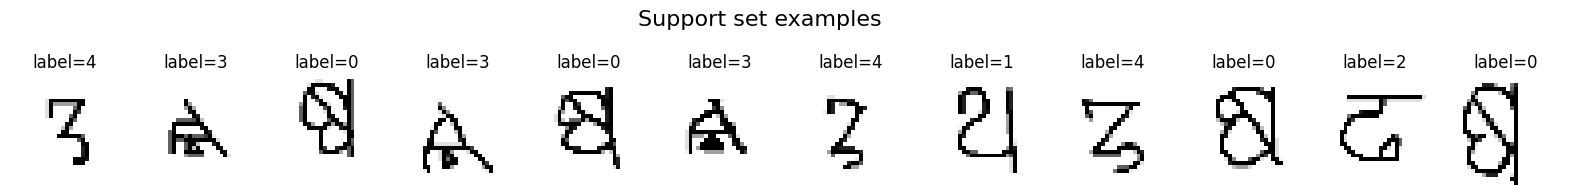

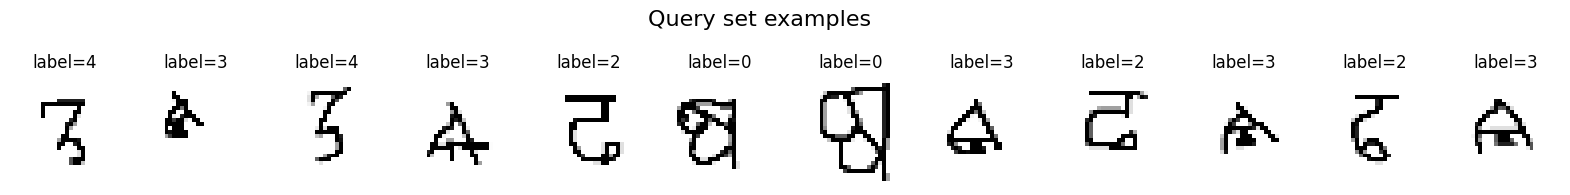

Task 1 | Query Set Loss 0.4316 | Support Set Average Acc 93.33% | Query Set Task Acc 93.33%




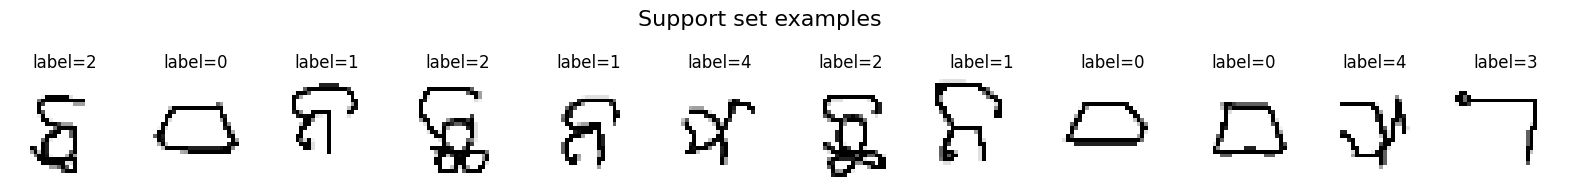

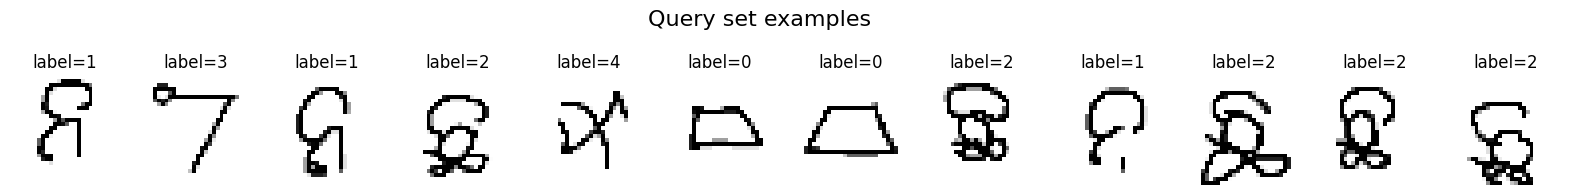

Task 2 | Query Set Loss 0.3094 | Support Set Average Acc 95.00% | Query Set Task Acc 96.67%




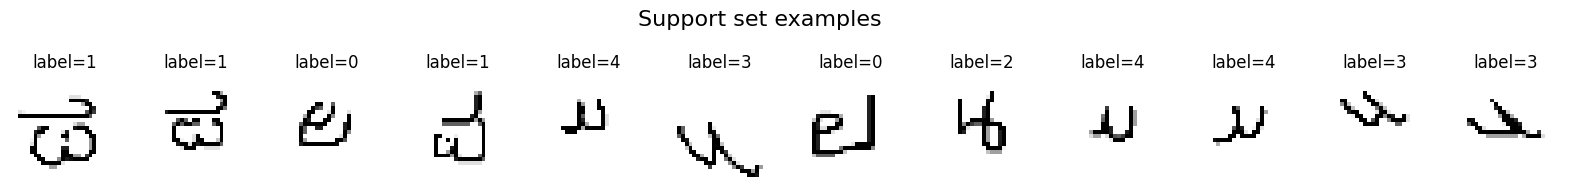

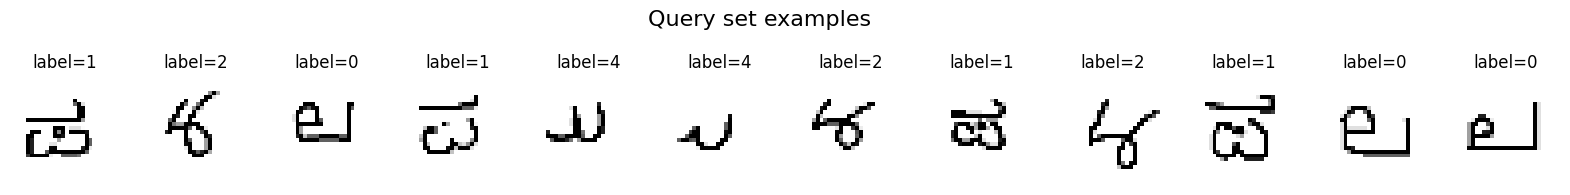

Task 3 | Query Set Loss 0.4628 | Support Set Average Acc 94.44% | Query Set Task Acc 93.33%




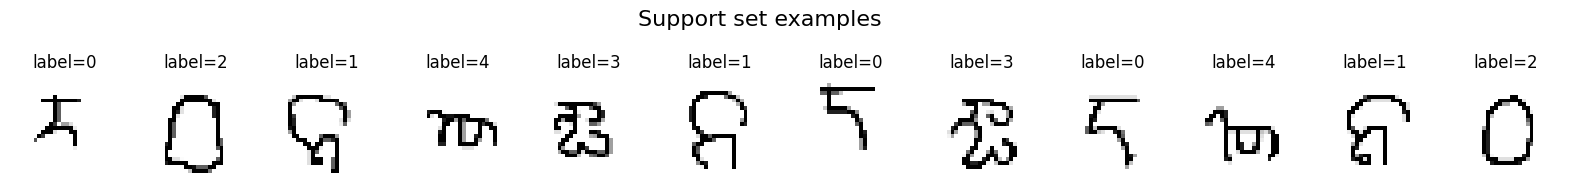

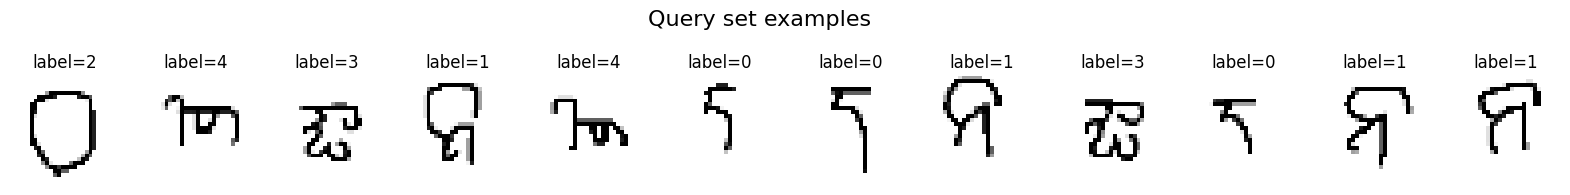

Task 4 | Query Set Loss 0.4089 | Support Set Average Acc 93.33% | Query Set Task Acc 90.00%




In [23]:
meta_test(model=omniglot_model, dataset={'X': X_test, 'labels': labels_test}, n_way=5, k_shot=6, grad_steps=6)

Obserwacja: Pomimo większej trudności testowego zbioru danych niż w przypadku MNIST, jesteśmy w stanie szybko douczyć nasz model CNN, aby uzyskał dość dobre wyniki n-way klasyfikacji na nieznanych mu przedtem klasach.

# A jak to będzie wyglądać, gdy wykorzystamy w algorytmie aproksymację poprzez gradient pierwszego stopnia?

W artykule [1] autorzy proponowali uproszczenie obliczeń i zamiast brania gradientu gradientu w minimalizacji funkcji kosztu, wykorzystali aproksymację poprzez pierwszy gradient. Twierdzili, że wyniki różniły się nieznacznie, a oszczędziło im to obliczeń i pamięci.

Batch 1 | Average Query Set Loss 0.9678 | Support Set Average Acc 81.60% | Last Query Set Acc 76.00%
Batch 2 | Average Query Set Loss 0.8459 | Support Set Average Acc 84.40% | Last Query Set Acc 78.00%
Batch 3 | Average Query Set Loss 0.8430 | Support Set Average Acc 84.40% | Last Query Set Acc 80.00%
Batch 4 | Average Query Set Loss 0.6470 | Support Set Average Acc 92.00% | Last Query Set Acc 86.00%
Batch 5 | Average Query Set Loss 0.7300 | Support Set Average Acc 82.00% | Last Query Set Acc 70.00%
Batch 6 | Average Query Set Loss 0.6610 | Support Set Average Acc 87.60% | Last Query Set Acc 86.00%
Batch 7 | Average Query Set Loss 0.5423 | Support Set Average Acc 91.60% | Last Query Set Acc 94.00%
Batch 8 | Average Query Set Loss 0.6308 | Support Set Average Acc 89.60% | Last Query Set Acc 86.00%
Batch 9 | Average Query Set Loss 0.5504 | Support Set Average Acc 92.40% | Last Query Set Acc 96.00%
Batch 10 | Average Query Set Loss 0.6492 | Support Set Average Acc 84.80% | Last Query Set 

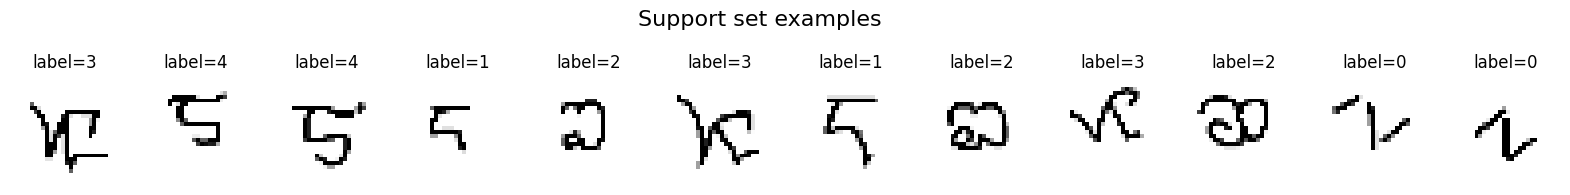

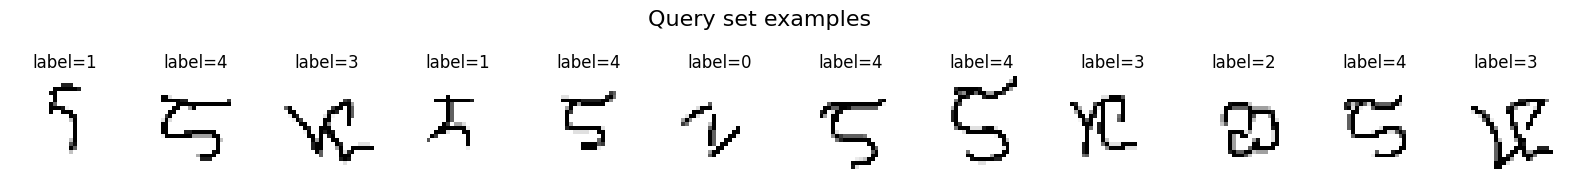

Task 1 | Query Set Loss 0.5728 | Support Set Average Acc 83.33% | Query Set Task Acc 83.33%




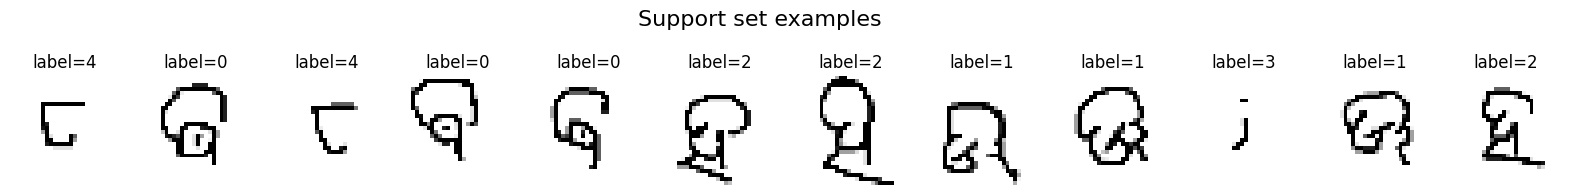

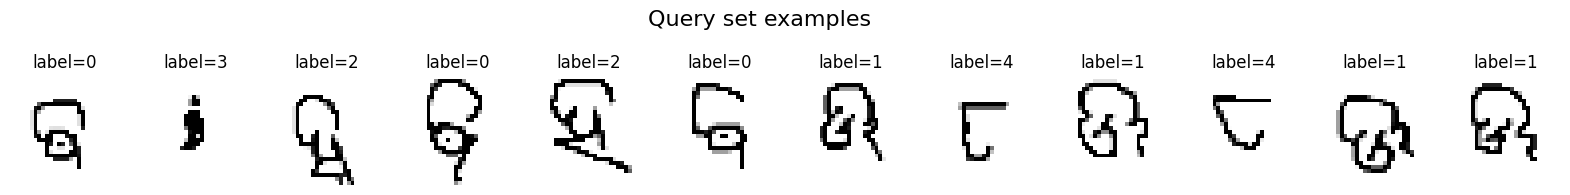

Task 2 | Query Set Loss 0.5688 | Support Set Average Acc 83.33% | Query Set Task Acc 83.33%




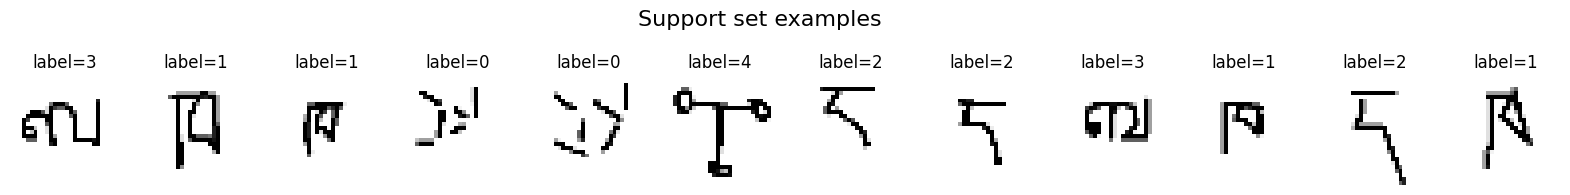

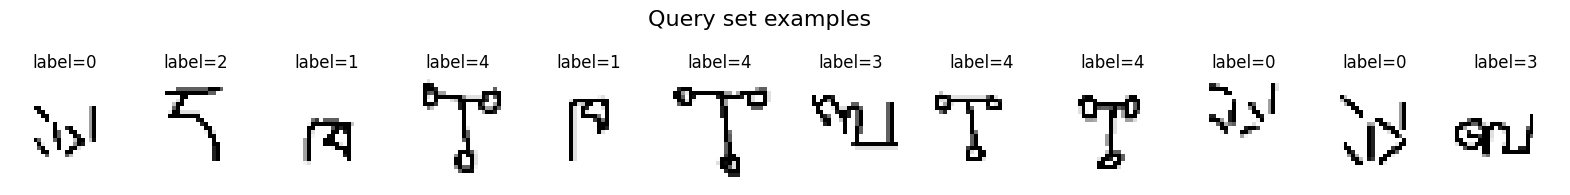

Task 3 | Query Set Loss 0.3650 | Support Set Average Acc 87.78% | Query Set Task Acc 96.67%




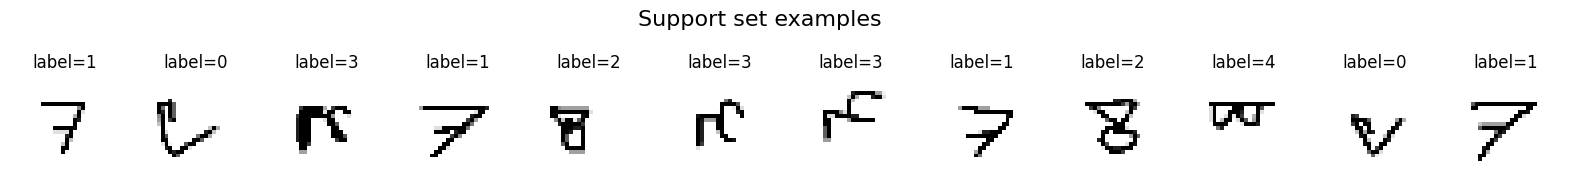

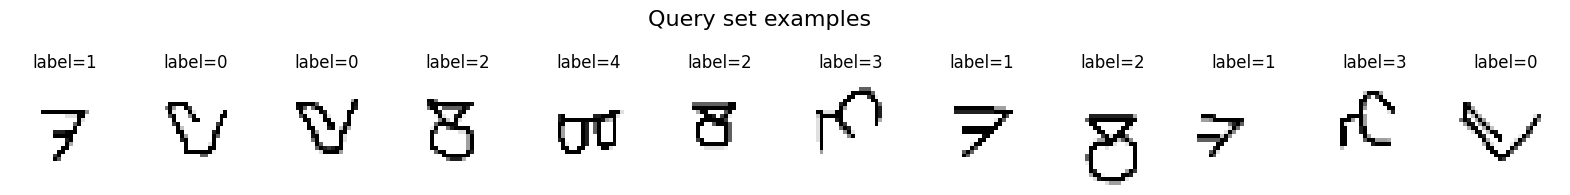

Task 4 | Query Set Loss 0.5710 | Support Set Average Acc 89.17% | Query Set Task Acc 93.33%




In [27]:
omniglot_model_2 = train_with_MAML({'X': X, 'labels': labels}, n_way = 5, k_shot = 10, grad_steps = 5, n_task = 5, n_batches=20, approx=True)
print("*************************************************")
meta_test(model=omniglot_model_2, dataset={'X': X_test, 'labels': labels_test}, n_way=5, k_shot=6, grad_steps=6)

Obserwacja: model w przypadku aproksymacji trochę wolniej się uczył ("Average Query Set Loss" zaczął odpowiednio spadać na nieco późniejszym etapie treningu). Można oczywiście puścić uczenie na większej liczbie batchy zadań, ze względu na zmniejszoną liczbę gradientów i zobaczyć, co wtedy się stanie.

# Zadanie 2. (punkotwane)
### Czym różni się etap meta-testu w przykładzie na zbiorze danych Omniglot w porównaniu z MNIST? Dlaczego ten etap działa dla klas, których model wcześniej nie widział (podczas gdy model trenowany w zwykłym nadzorowanym ustawieniu nie dałby dobrych wyników)?

Odpowiedź:

W przypadku zbioru MNIST zarówno podczas meta-learningu jak i meta-testu działamy na podzbiorach tych samych cyfr (klas). W zbiorze Omniglot zadbano o to, aby zbiory testowy i treningowy zawierały rozdzielne alfabety - tak, żeby model był testowany na danych, których jeszcze nie widział i które będą znacząco różnić się od treningowych przykładów.

Zauważmy, że podczas etapu meta-testu nasz model wciąż wykonuje backward pass i doucza swoje parametry, dostosowując się do nowo poznanych przykładów. W zwykłym ustawieniu uczenia nadzorowanego, na zbiorze testowym dokonujemy tylko ewaluacji - sprawdzamy jakość predykcji. Wtedy model, widząc przykłady zupełnie nowych klas, nie poradziłby sobie z ich klasyfikacją.

Za to, ile takich dostosowań parametrów (kroków gradientowych) będziemy wykonywać w fazie meta-testu, odpowiada atrybut *task_update_num*.

# Zadanie dodatkowe:

### W kodzie wykorzystywaliśmy liczenie gradientu względem weights.fast przy pomocy torch.autograd.grad. Napisz funkcję, która będzie obliczać N-tą pochodną (N-ty gradient).

Podpowiedź: Zapoznaj się z [7], wykorzystaj retain_graph=True oraz grad_outputs=torch.ones_like(...) - sztuczka implementacyjna.

In [ ]:
def df(output: torch.Tensor, input: torch.Tensor, n: int = 1) -> torch.Tensor:
    """Compute the n-th neural network derivative with respect to the input features"""

    derivative_val = output  # initialize a variable which will store the next derivatives

    for _ in range(n):
        derivative_val = torch.autograd.grad(
            derivative_val,  # get grad with respect to the previous derivative
            input,
            grad_outputs=torch.ones_like(derivative_val),
            create_graph=True,
            retain_graph=True,
        )[0]

    return derivative_val

# Podsumowanie

W tym notebooku pokazaliśmy, że algorytm MAML może zostać wykorzystany także do trenowania innej architektury niż prosta sieć fully connected.
Poznaliśmy przykłady n-way k-shot klasyfikacji na zbiorach MNIST i Omniglot, omówiliśmy różnice w trudności tych zbiorów, a także powiedzieliśmy sobie, w jaki sposób Support oraz Query są wykorzystywane inaczej w ustawieniu few-shot MAML względem podstawowego ustawienia few-shot learningu.


# Źródła
[1] MAML: https://arxiv.org/pdf/1703.03400.pdf

[2] Few Shot Learning repository: https://github.com/cnguyen10/few_shot_meta_learning/tree/master

[3] Few Shot Learning basic concepts: https://www.youtube.com/watch?v=hE7eGew4eeg

[4] Meta Learning: https://www.youtube.com/watch?v=YkeE7oRxF24&t=1s

[5] Google Colab HyperMAML: https://colab.research.google.com/drive/1hqY8rp8aRVm_a7DvIBHH_MHf0c9URQpn?usp=sharing

[6] Omniglot dataset paper: https://www.science.org/doi/abs/10.1126/science.aab3050

[7] PyTorch autograd tutorial: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html